### Assignment 3 Version 2 

##### Deliar Mohammadi, 30072994
##### John Zheng,30125258
##### Xinzhou Li, 30066080



In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch_optimizer as optim
# from torchsummary import summary
from torchvision.models import resnet50, ResNet50_Weights, ResNet101_Weights, ResNet152_Weights

import PIL
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import random
import os
import glob
from tqdm import tqdm

# Data Classes

In [2]:
class Data():
    def __init__(self, root, paths, labels, transform=None, ext='.jpg'): # move transform into training loop
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.root = root
        
    '''
    return length of the dataset
    '''
    def __len__(self):
        return len(self.paths)
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label
     
    '''
    get the img,label tuple corresponding to index i
    '''
    def get_no_transform(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        label = self.labels[i] if self.labels else None
        return img, label
    
    '''
    Selects random start point in the dataset and prints 28 images
    '''
    def print_samples(self):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, len(self)-29)
        
        for axis in axes:
            x = self.get_no_transform(i)
            axis.imshow(x[0])
            label = x[1]
            axis.set_xlabel(label)
            i+=1
        plt.tight_layout()
        plt.show()
    
    '''
    Calculates average width and height of all images in dataset
    '''
    def calc_average_dimension(self):
        totalw = 0
        totalh = 0
        for i in range(len(self.paths)):
            image = (self.get_no_transform(i))[0]
            w, h = image.size
            totalw += w
            totalh += h
        avgw = totalw//len(self)
        avgh = totalh//len(self)
        return avgw, avgh

In [3]:
class TestData():
    def __init__(self, root, paths,transform=None, ext='.jpg'): # move transform into training loop
        self.paths = paths
        self.transform = transform
        self.root = root
        
    '''
    return length of the dataset
    '''
    def __len__(self):
        return len(self.paths)
    
    '''
    get the img in index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        img = self.transform(img)
        return img
    
    '''
    predict output for each test image
    '''
    def predict(self, dataloader, model):
        all_preds = torch.Tensor([]).to(device) # specify dtype
        model.eval()
        for batch_index,images in enumerate(dataloader):
            test_images = images.to(device)
            outputs = model(test_images)
            _,preds = torch.max(outputs,1) # calcualtae max in each column (second value=1 for column)
            all_preds = torch.cat((all_preds,preds))
        preds = all_preds.tolist()
        preds = [int(x) for x in all_preds]
        return preds
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def get_no_transform(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        return img
    
    '''
    print sample data from test
    '''
    def print_samples(self):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, len(self)-29)
        
        for axis in axes:
            x = self.get_no_transform(i)
            axis.imshow(x)
            i+=1
        plt.tight_layout()
        plt.show()
    
    '''
    write predictions into answer.csv for submission to kaggle
    '''
    def write_predictions(self, predictions, csv_file, output_file):
        file = pd.read_csv(self.root+"/"+csv_file)
        file['Predicted'] = predictions
        file.to_csv(output_file, sep=',', index=False)


# The Model Class

In [4]:
class A3ResNetV2():
    def __init__(self, device):
        self.device = device
        
        self.model = models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V2).to(self.device)
        
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.Tanh(),
            nn.Dropout(0.05),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 100),
        )
        
        self.model.fc = self.fc
        self.model.to(self.device)
    
    '''
    freeze all feature layers in the network, does not freeze the fully
    connected layer at the end
    '''
    def freeze_features(self):
        for name,param in self.model.named_parameters():
            if "fc" in name:
                continue
            else:
                param.requires_grad=False
    
    '''
    unfreeze all features, gradient calculates for all conv layers with this called
    '''
    def unfreeze_features(self):
        for param in self.model.parameters():
            param.requires_grad = True
    
    '''
    helper function to check which layers have gradient calculating.
    Yes means its being updated, and No is not updated
    '''
    def print_grad_settings(self):
        for i in self.model.parameters():
            if i.requires_grad==True:
                print("YES")
            else:
                print("NO")
    
    '''
    helper function to print model and summary
    '''
    def print_model(self):
        summary(self.model, (3,224,224))
    
    '''
    function to train the model on a given dataloader,optimizer, and loss function.
    runs for specified number of epochs.
    '''
    def train_model(self, epochs, train_dataloader, optimizer, loss_function, scheduler):
        self.model.train()
        for i in tqdm(range(epochs)):
            
            epoch_loss = 0
            num_examples = 0
            correct_examples = 0
            
            for batch_index,(images,labels) in enumerate(train_dataloader):
                # reset optimizer for the current batch
                optimizer.zero_grad() 
                # load images and labels
                images = images.to(device)
                labels = labels.to(device)
                # calculate output and loss from output
                outputs = self.model(images)
                loss = loss_function(outputs,labels)
                # loss.backward() calculates all gradients for all params, optimizer.step() updates params using our optimizer
                loss.backward()
                optimizer.step()
                # calculate information for this epoch
                epoch_loss += loss.item()*len(labels)
                num_examples += len(labels)
                # calculate predictions and accuracy
                _,preds = torch.max(outputs,1) # calcualtae max in each column (second value=1 for column)
                # print("Preds",preds)
                correct_examples += (preds==labels).sum().item()
            
            # AFTER epoch we calculate accuracy and step scheduler
            train_accuracy = (correct_examples/num_examples)*100
            print(f'Epoch {i}: Training Accuracy: {train_accuracy:.4f}%, Training Loss: {epoch_loss:.4f}')
            scheduler.step()

    '''
    validates model on validation set
    '''
    def validate_model(self, validation_dataloader):
        self.model.eval() 
        num_examples = 0
        correct_examples = 0
        
        for batch_index,(images,labels) in tqdm(enumerate(validation_dataloader)):
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            num_examples += len(labels)
            _ , preds = torch.max(outputs,1)
            # print(preds)
            correct_examples += (preds==labels).sum().item()
            
        validation_accuracy = (correct_examples / num_examples)*100
        print(f'Validation Accuracy: {validation_accuracy:.20f}%')


# Data Preperation

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.05), scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.1),
    transforms.ColorJitter(contrast=0.1),
    transforms.ColorJitter(saturation=0.1),
    
    transforms.Resize(size=(224,224)),       
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalized with imagenet mean and std deviation
])

In [6]:
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),      
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Old Resize:
# transforms.Resize(256),
# torchvision.transforms.CenterCrop(224),


##### Load the training and test paths from spreadsheets and setup the data loaders

In [7]:
df_csv = pd.DataFrame(pd.read_csv("./Assignment 3 Dataset/train.csv"))
train_paths = df_csv["id"].to_list()
train_labels = df_csv["label"].to_list()

test_csv = pd.DataFrame(pd.read_csv("./Assignment 3 Dataset/test.csv"))
test_paths = test_csv["id"].values

In [8]:
train_dataset = Data("./Assignment 3 Dataset", train_paths, train_labels, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TestData("./Assignment 3 Dataset", test_paths, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Sampels of training and test data

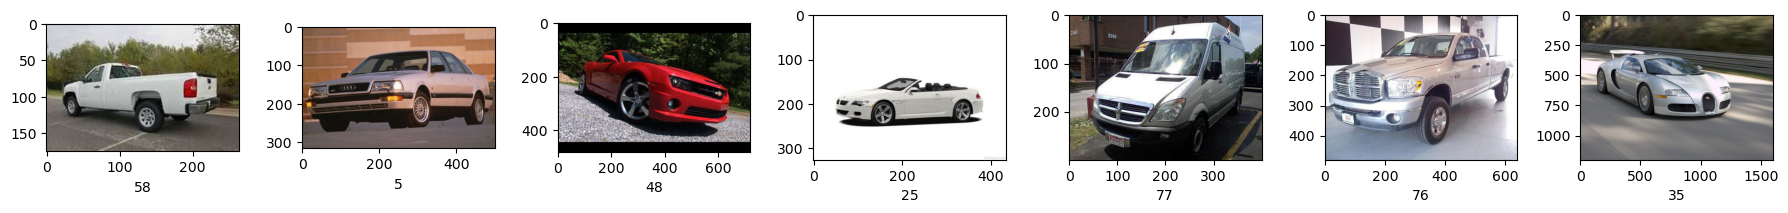

In [9]:
train_dataset.print_samples()

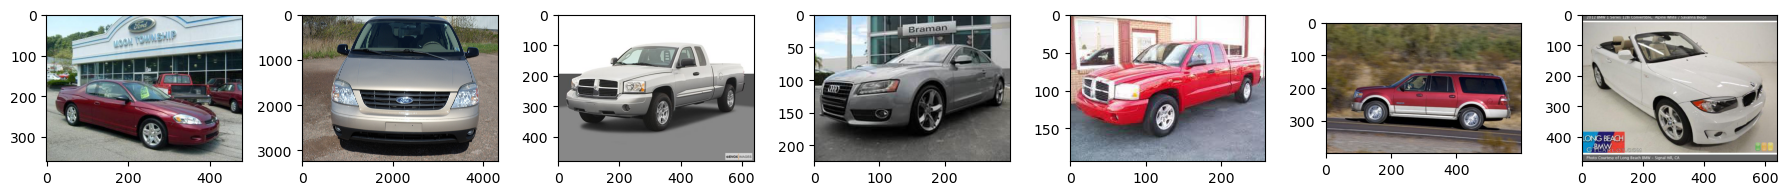

In [10]:
test_dataset.print_samples()

# Instantiating the Model and Making Predictions

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
resnet = A3ResNetV2(device)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to C:\Users\Lareina/.cache\torch\hub\checkpoints\resnet101-cd907fc2.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.model.parameters(), lr=0.1 , momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.87)

### Training

To begin training, we will first freeze the feature portion of the network and only train the fully connected layer (classifier) for several epochs.

We will then unfreeze the network and train the entire thing afterwards for many more epochs, and intermittantly make predictions intermitently

In [14]:
resnet.freeze_features()
for i in range(4):
    resnet.train_model(8, train_dataloader, optimizer, loss_function, scheduler)
    
    predictions = test_dataset.predict(test_dataloader, resnet.model) # make predictions on test with current model
    
    out_file_name = "answer_fully_connected"+str(i)+".csv"
    test_dataset.write_predictions(predictions, "/sample.csv", out_file_name) # write predictions to csv

 12%|█▎        | 1/8 [01:43<12:02, 103.17s/it]

Epoch 0: Training Accuracy: 2.6844%, Training Loss: 31112.7575


 25%|██▌       | 2/8 [03:13<09:34, 95.77s/it] 

Epoch 1: Training Accuracy: 1.4027%, Training Loss: 54068.5322


 38%|███▊      | 3/8 [04:40<07:38, 91.64s/it]

Epoch 2: Training Accuracy: 2.0073%, Training Loss: 44819.3166


 50%|█████     | 4/8 [06:07<05:59, 89.75s/it]

Epoch 3: Training Accuracy: 3.2648%, Training Loss: 33414.5944


 62%|██████▎   | 5/8 [07:33<04:25, 88.46s/it]

Epoch 4: Training Accuracy: 3.8936%, Training Loss: 30258.5775


 75%|███████▌  | 6/8 [09:00<02:55, 87.89s/it]

Epoch 5: Training Accuracy: 4.0871%, Training Loss: 27806.9927


 88%|████████▊ | 7/8 [10:26<01:27, 87.41s/it]

Epoch 6: Training Accuracy: 5.4172%, Training Loss: 25261.3253


100%|██████████| 8/8 [11:53<00:00, 89.14s/it]

Epoch 7: Training Accuracy: 5.8041%, Training Loss: 23259.6440



 12%|█▎        | 1/8 [01:26<10:05, 86.45s/it]

Epoch 0: Training Accuracy: 6.1427%, Training Loss: 21897.1468


 25%|██▌       | 2/8 [02:52<08:37, 86.23s/it]

Epoch 1: Training Accuracy: 8.4643%, Training Loss: 20242.8997


 38%|███▊      | 3/8 [04:19<07:13, 86.66s/it]

Epoch 2: Training Accuracy: 8.4160%, Training Loss: 19340.2146


 50%|█████     | 4/8 [05:46<05:47, 86.91s/it]

Epoch 3: Training Accuracy: 9.9637%, Training Loss: 17675.5925


 62%|██████▎   | 5/8 [07:14<04:21, 87.24s/it]

Epoch 4: Training Accuracy: 9.9879%, Training Loss: 16842.2856


 75%|███████▌  | 6/8 [08:42<02:54, 87.45s/it]

Epoch 5: Training Accuracy: 11.2455%, Training Loss: 16057.6656


 88%|████████▊ | 7/8 [10:08<01:27, 87.08s/it]

Epoch 6: Training Accuracy: 13.2044%, Training Loss: 15336.2449


100%|██████████| 8/8 [11:35<00:00, 86.95s/it]

Epoch 7: Training Accuracy: 14.2443%, Training Loss: 14869.5713



 12%|█▎        | 1/8 [01:26<10:04, 86.37s/it]

Epoch 0: Training Accuracy: 15.2842%, Training Loss: 14230.9401


 25%|██▌       | 2/8 [03:02<09:12, 92.04s/it]

Epoch 1: Training Accuracy: 15.6469%, Training Loss: 13797.6458


 38%|███▊      | 3/8 [04:30<07:31, 90.32s/it]

Epoch 2: Training Accuracy: 16.2515%, Training Loss: 13390.2906


 50%|█████     | 4/8 [05:56<05:54, 88.68s/it]

Epoch 3: Training Accuracy: 17.2914%, Training Loss: 13097.2249


 62%|██████▎   | 5/8 [07:24<04:24, 88.20s/it]

Epoch 4: Training Accuracy: 18.4764%, Training Loss: 12879.1605


 75%|███████▌  | 6/8 [08:50<02:55, 87.64s/it]

Epoch 5: Training Accuracy: 18.5973%, Training Loss: 12757.1386


 88%|████████▊ | 7/8 [10:17<01:27, 87.40s/it]

Epoch 6: Training Accuracy: 19.7823%, Training Loss: 12398.6732


100%|██████████| 8/8 [11:44<00:00, 88.12s/it]

Epoch 7: Training Accuracy: 20.5562%, Training Loss: 12080.2590



 12%|█▎        | 1/8 [01:26<10:04, 86.39s/it]

Epoch 0: Training Accuracy: 20.9432%, Training Loss: 12076.7441


 25%|██▌       | 2/8 [02:52<08:38, 86.46s/it]

Epoch 1: Training Accuracy: 22.7086%, Training Loss: 11869.8531


 38%|███▊      | 3/8 [04:19<07:12, 86.50s/it]

Epoch 2: Training Accuracy: 21.7412%, Training Loss: 11908.8521


 50%|█████     | 4/8 [05:45<05:46, 86.51s/it]

Epoch 3: Training Accuracy: 23.0955%, Training Loss: 11588.9138


 62%|██████▎   | 5/8 [07:12<04:19, 86.46s/it]

Epoch 4: Training Accuracy: 22.7328%, Training Loss: 11642.9856


 75%|███████▌  | 6/8 [08:38<02:52, 86.35s/it]

Epoch 5: Training Accuracy: 23.7727%, Training Loss: 11468.1886


 88%|████████▊ | 7/8 [10:04<01:26, 86.32s/it]

Epoch 6: Training Accuracy: 21.9589%, Training Loss: 11671.1638


100%|██████████| 8/8 [11:31<00:00, 86.41s/it]

Epoch 7: Training Accuracy: 23.6276%, Training Loss: 11381.5726


In [15]:
resnet.unfreeze_features()
for i in range(8):
    
    resnet.train_model(8, train_dataloader, optimizer, loss_function, scheduler) # train the model for 9 epochs

    predictions = test_dataset.predict(test_dataloader, resnet.model) # make predictions on test with current model
    
    out_file_name = "answer"+str(i)+".csv"
    test_dataset.write_predictions(predictions, "/sample.csv", out_file_name) # write predictions to csv

 12%|█▎        | 1/8 [01:34<10:59, 94.18s/it]

Epoch 0: Training Accuracy: 24.5949%, Training Loss: 11335.8784


 25%|██▌       | 2/8 [03:07<09:22, 93.81s/it]

Epoch 1: Training Accuracy: 31.1487%, Training Loss: 9701.5550


 38%|███▊      | 3/8 [04:41<07:49, 93.93s/it]

Epoch 2: Training Accuracy: 38.4522%, Training Loss: 8650.1166


 50%|█████     | 4/8 [06:15<06:15, 93.79s/it]

Epoch 3: Training Accuracy: 42.6119%, Training Loss: 8065.2337


 62%|██████▎   | 5/8 [07:49<04:41, 93.75s/it]

Epoch 4: Training Accuracy: 47.0859%, Training Loss: 7452.4553


 75%|███████▌  | 6/8 [09:22<03:07, 93.79s/it]

Epoch 5: Training Accuracy: 50.0846%, Training Loss: 7047.4948


 88%|████████▊ | 7/8 [10:56<01:33, 93.88s/it]

Epoch 6: Training Accuracy: 53.6880%, Training Loss: 6640.3812


100%|██████████| 8/8 [12:31<00:00, 93.88s/it]

Epoch 7: Training Accuracy: 55.2358%, Training Loss: 6418.1620



 12%|█▎        | 1/8 [01:35<11:05, 95.07s/it]

Epoch 0: Training Accuracy: 58.3071%, Training Loss: 6065.5604


 25%|██▌       | 2/8 [03:10<09:31, 95.17s/it]

Epoch 1: Training Accuracy: 60.3869%, Training Loss: 5785.4966


 38%|███▊      | 3/8 [04:45<07:55, 95.11s/it]

Epoch 2: Training Accuracy: 63.0713%, Training Loss: 5596.1812


 50%|█████     | 4/8 [06:20<06:20, 95.02s/it]

Epoch 3: Training Accuracy: 63.0472%, Training Loss: 5444.2587


 62%|██████▎   | 5/8 [07:55<04:45, 95.04s/it]

Epoch 4: Training Accuracy: 65.5139%, Training Loss: 5288.7540


 75%|███████▌  | 6/8 [09:29<03:09, 94.90s/it]

Epoch 5: Training Accuracy: 65.8041%, Training Loss: 5167.3870


 88%|████████▊ | 7/8 [11:04<01:34, 94.84s/it]

Epoch 6: Training Accuracy: 67.5695%, Training Loss: 5050.7873


100%|██████████| 8/8 [12:39<00:00, 94.98s/it]

Epoch 7: Training Accuracy: 68.8271%, Training Loss: 4933.0995



 12%|█▎        | 1/8 [01:34<11:04, 94.93s/it]

Epoch 0: Training Accuracy: 69.6977%, Training Loss: 4935.0893


 25%|██▌       | 2/8 [03:11<09:36, 96.01s/it]

Epoch 1: Training Accuracy: 69.1898%, Training Loss: 4792.9708


 38%|███▊      | 3/8 [04:49<08:03, 96.68s/it]

Epoch 2: Training Accuracy: 70.9069%, Training Loss: 4719.1774


 50%|█████     | 4/8 [06:24<06:24, 96.23s/it]

Epoch 3: Training Accuracy: 71.3664%, Training Loss: 4644.9008


 62%|██████▎   | 5/8 [07:59<04:47, 95.72s/it]

Epoch 4: Training Accuracy: 71.3906%, Training Loss: 4622.9121


 75%|███████▌  | 6/8 [09:34<03:10, 95.49s/it]

Epoch 5: Training Accuracy: 71.2455%, Training Loss: 4587.4374


 88%|████████▊ | 7/8 [11:09<01:35, 95.27s/it]

Epoch 6: Training Accuracy: 71.4389%, Training Loss: 4560.9563


100%|██████████| 8/8 [12:44<00:00, 95.54s/it]

Epoch 7: Training Accuracy: 73.3253%, Training Loss: 4513.9635



 12%|█▎        | 1/8 [01:34<11:03, 94.74s/it]

Epoch 0: Training Accuracy: 72.1403%, Training Loss: 4541.9451


 25%|██▌       | 2/8 [03:10<09:30, 95.10s/it]

Epoch 1: Training Accuracy: 72.8658%, Training Loss: 4497.6412


 38%|███▊      | 3/8 [04:45<07:55, 95.05s/it]

Epoch 2: Training Accuracy: 72.7932%, Training Loss: 4416.1027


 50%|█████     | 4/8 [06:19<06:19, 95.00s/it]

Epoch 3: Training Accuracy: 72.9867%, Training Loss: 4437.4972


 62%|██████▎   | 5/8 [07:54<04:44, 94.95s/it]

Epoch 4: Training Accuracy: 73.5429%, Training Loss: 4404.3974


 75%|███████▌  | 6/8 [09:29<03:09, 94.92s/it]

Epoch 5: Training Accuracy: 73.1318%, Training Loss: 4396.0730


 88%|████████▊ | 7/8 [11:04<01:34, 94.98s/it]

Epoch 6: Training Accuracy: 72.7932%, Training Loss: 4449.8131


100%|██████████| 8/8 [12:39<00:00, 94.99s/it]

Epoch 7: Training Accuracy: 72.7690%, Training Loss: 4420.9964



 12%|█▎        | 1/8 [01:34<11:03, 94.74s/it]

Epoch 0: Training Accuracy: 73.0593%, Training Loss: 4390.2790


 25%|██▌       | 2/8 [03:09<09:28, 94.81s/it]

Epoch 1: Training Accuracy: 73.5913%, Training Loss: 4342.6860


 38%|███▊      | 3/8 [04:44<07:54, 94.98s/it]

Epoch 2: Training Accuracy: 73.9782%, Training Loss: 4334.3146


 50%|█████     | 4/8 [06:19<06:20, 95.03s/it]

Epoch 3: Training Accuracy: 74.4135%, Training Loss: 4338.9703


 62%|██████▎   | 5/8 [07:55<04:45, 95.12s/it]

Epoch 4: Training Accuracy: 74.3894%, Training Loss: 4341.9920


 75%|███████▌  | 6/8 [09:30<03:10, 95.06s/it]

Epoch 5: Training Accuracy: 73.7122%, Training Loss: 4330.0476


 88%|████████▊ | 7/8 [11:05<01:35, 95.02s/it]

Epoch 6: Training Accuracy: 74.2201%, Training Loss: 4335.7422


100%|██████████| 8/8 [12:39<00:00, 94.99s/it]

Epoch 7: Training Accuracy: 74.8489%, Training Loss: 4311.2477



 12%|█▎        | 1/8 [01:34<11:04, 95.00s/it]

Epoch 0: Training Accuracy: 73.6155%, Training Loss: 4363.3492


 25%|██▌       | 2/8 [03:10<09:30, 95.06s/it]

Epoch 1: Training Accuracy: 74.8730%, Training Loss: 4337.7441


 38%|███▊      | 3/8 [04:45<07:55, 95.16s/it]

Epoch 2: Training Accuracy: 74.8247%, Training Loss: 4314.3787


 50%|█████     | 4/8 [06:20<06:20, 95.16s/it]

Epoch 3: Training Accuracy: 74.3410%, Training Loss: 4319.9384


 62%|██████▎   | 5/8 [07:55<04:45, 95.08s/it]

Epoch 4: Training Accuracy: 74.6312%, Training Loss: 4306.1321


 75%|███████▌  | 6/8 [09:30<03:10, 95.07s/it]

Epoch 5: Training Accuracy: 74.9214%, Training Loss: 4318.0954


 88%|████████▊ | 7/8 [11:05<01:35, 95.08s/it]

Epoch 6: Training Accuracy: 74.2201%, Training Loss: 4334.0729


100%|██████████| 8/8 [12:40<00:00, 95.06s/it]

Epoch 7: Training Accuracy: 73.5187%, Training Loss: 4343.6305



 12%|█▎        | 1/8 [01:34<11:03, 94.82s/it]

Epoch 0: Training Accuracy: 75.1391%, Training Loss: 4282.6172


 25%|██▌       | 2/8 [03:09<09:29, 94.92s/it]

Epoch 1: Training Accuracy: 74.1233%, Training Loss: 4366.4014


 38%|███▊      | 3/8 [04:44<07:54, 94.94s/it]

Epoch 2: Training Accuracy: 73.5671%, Training Loss: 4353.4064


 50%|█████     | 4/8 [06:19<06:19, 94.95s/it]

Epoch 3: Training Accuracy: 74.7037%, Training Loss: 4286.5224


 62%|██████▎   | 5/8 [07:54<04:44, 94.91s/it]

Epoch 4: Training Accuracy: 74.3410%, Training Loss: 4337.6294


 75%|███████▌  | 6/8 [09:29<03:09, 94.87s/it]

Epoch 5: Training Accuracy: 73.4462%, Training Loss: 4364.9184


 88%|████████▊ | 7/8 [11:04<01:35, 95.01s/it]

Epoch 6: Training Accuracy: 74.8730%, Training Loss: 4310.2368


100%|██████████| 8/8 [12:39<00:00, 94.90s/it]

Epoch 7: Training Accuracy: 74.2201%, Training Loss: 4323.4989



 12%|█▎        | 1/8 [01:34<11:03, 94.79s/it]

Epoch 0: Training Accuracy: 74.3652%, Training Loss: 4299.4540


 25%|██▌       | 2/8 [03:09<09:28, 94.72s/it]

Epoch 1: Training Accuracy: 75.4051%, Training Loss: 4269.6737


 38%|███▊      | 3/8 [04:49<08:05, 97.07s/it]

Epoch 2: Training Accuracy: 74.6796%, Training Loss: 4281.1104


 50%|█████     | 4/8 [06:28<06:31, 97.98s/it]

Epoch 3: Training Accuracy: 74.9698%, Training Loss: 4273.3588


 62%|██████▎   | 5/8 [08:03<04:50, 96.93s/it]

Epoch 4: Training Accuracy: 74.1717%, Training Loss: 4343.8263


 75%|███████▌  | 6/8 [09:38<03:12, 96.28s/it]

Epoch 5: Training Accuracy: 73.2285%, Training Loss: 4371.5364


 88%|████████▊ | 7/8 [11:14<01:36, 96.08s/it]

Epoch 6: Training Accuracy: 74.1959%, Training Loss: 4367.3224


100%|██████████| 8/8 [12:49<00:00, 96.25s/it]

Epoch 7: Training Accuracy: 74.4377%, Training Loss: 4354.9611


### Sources

https://pytorch.org/vision/stable/models.html

https://discuss.pytorch.org/t/what-does-it-mean-to-normalize-images-for-resnet/96160